In [1]:
from numpy.random import rand,randn
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd

# Continuous model
#### Auxiliary functions:

$$\Gamma_i(p)=1-\frac{1-\exp\Big(-\frac{(p-p^*_i)^2}{2\sigma^2}\Big)}{1-\exp\Big(-\frac{p_c^2}{2\sigma^2}\Big)}\;,\qquad \forall i=1,\ldots,S \;.$$

The functions $\Gamma_i$ depend on species $i$ only through $p_i^*$. We take these values evenly spaced in a given interval.


#### ODEs:
$$\frac{{\rm d} n_i(t)}{{\rm d}t}=\alpha\, n_i(t)\Big(1-\frac{n_i(t)}K+\Gamma_i(p)\Big)+\lambda\;,\qquad \forall i=1,\ldots,S$$

$$\frac{{\rm d} p(t)}{{\rm d}t}=\frac{\alpha}{S}\sum_{i=1}^S b_i \,\frac{{\rm d} n_i(t)}{{\rm d}t}\Theta\Big(\frac{{\rm d} n_i(t)}{{\rm d}t}\Big)-{\rm fl}\, \Big(p(t)-1\Big)\qquad$$

There is no migration ($\lambda=0$) and $b_2=0$.

In [2]:
def Gamma_p(p,p_opt,pc,sig2):
    return 1-(1-np.exp(-(p-p_opt)**2/2/(sig2)))/(1-np.exp(-pc**2/2/(sig2)))

In [3]:
def dn_dt_p_continuous(n,p,al,K,p_opt_vec,pc,sig2,lam=0):
    return al*n*(1 - n/K +Gamma_p(p,p_opt_vec,pc,sig2))+lam

def dp_dt_continuous(n,p,b,al,K,p_opt_vec,pc,sig2,fl,tol):
    return (al/S)*np.sum( np.multiply(b,dn_dt_p_continuous(n,p,al,K,p_opt_vec,pc,sig2))*(dn_dt_p_continuous(n,p,al,K,p_opt_vec,pc,sig2)>tol) )  - fl*(p-1)

def dnp_dt_continuous(t,np,al,b,K,p_opt_vec,pc,sig2,fl,tol):
    S=int(len(np)-1)
    dx1=dn_dt_p_continuous(np[:S],np[S],al,K,p_opt_vec,pc,sig2)*(np[:S]>tol)
    dx2=dp_dt_continuous(np[:S],np[S],b,al,K,p_opt_vec,pc,sig2,fl,tol)
    dx1=dx1.tolist()
    dx1.append(dx2)
    return dx1

### Numerical integration 

In [4]:
def continuous_dilution(S,t0,tend,np0,my_args,dt=.1):

    result_ivp=solve_ivp(dnp_dt_continuous,(t0,tend),np0,args=my_args,t_eval=np.arange(t0,tend,dt),rtol=1e-13, atol=1e-13) 
    time=result_ivp.t
    NPt=result_ivp.y

    return time,NPt

### Parameters

In [5]:
# S = 50
# bconst=20

# pc = 0.4
# sig2 = 1
# K = 1
# al = 5
# fl = 0 #stabilize p
# left_nb=int(S)
# left_ps= np.linspace(.0,2.,left_nb)
# right_ps= np.linspace(2.5,3.,S-left_nb)
# p_opt_vec = np.concatenate([left_ps,right_ps]) # this needs not to be centered in 1

# b = bconst/(1-p_opt_vec)

# # b = bconst*np.linspace(-1,1,S)
# # b=np.flip(b)

# tol=1e-16

# my_args=(al,b,K,p_opt_vec,pc,sig2,fl,tol)

# t0=0.
# tend=500
# dt=.1

In [6]:
## Limit cycles:

S = 50

pc = 0.4
sig2 = 1
K = 1
al = 1
fl = 1 #stabilize p
pmin=1.1
pmax=2
pmid=(pmin+pmax)/2
p_opt_vec = np.linspace(pmin,pmax,S) # this needs not to be centered in 1

bconst=15

b = bconst*np.linspace(-1,1,S)
b=np.flip(b)

# Farlo Gaussiano centrato intorno a pvec
tol=1e-20

my_args=(al,b,K,p_opt_vec,pc,sig2,fl,tol)

t0=0.
tend=1500
dt=.1

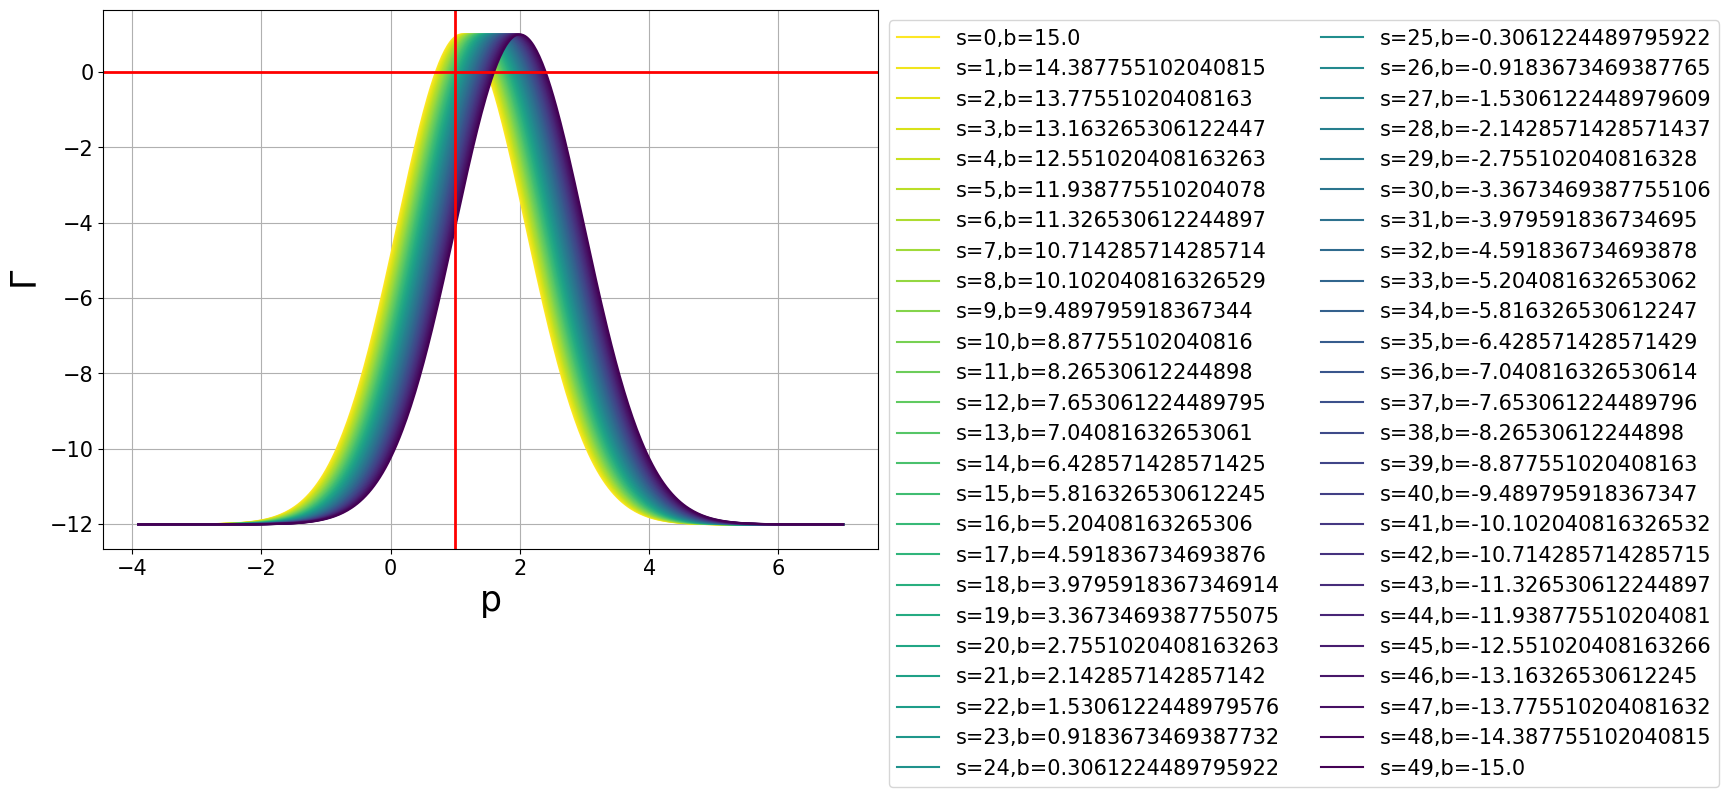

In [7]:
fig,ax=plt.subplots(1,figsize=(10,7))
plt.grid()

colors = pl.cm.viridis_r(np.linspace(0,1,S))
col=0
pps=np.linspace(min(p_opt_vec)-5*sig2,max(p_opt_vec)+5*sig2,500)

for s in range(S):
    plt.plot(pps,Gamma_p(pps,p_opt_vec[s],pc,sig2),label="s={},b={}".format(s,b[s]),color=colors[col])
    col+=1
    
plt.ylabel("$\\Gamma$",fontsize=25)
plt.xlabel("p",fontsize=25)
plt.legend(ncol=2,fontsize=15,bbox_to_anchor=(1.,1.))

plt.axhline(0,lw=2,color="red")
plt.axvline(1,lw=2,color="red")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

### Initialization

In [8]:
np0 = np.ones(S+1)
np0[:S] = 1e-5*np0[:S]/sum(np0[:S]) * K/2
np0[-1]=1
np0=np0.reshape(S+1,)

### Solving...

In [14]:
time_cont,NPt_cont=continuous_dilution(S,t0,tend,np0,my_args,dt)

### Plot

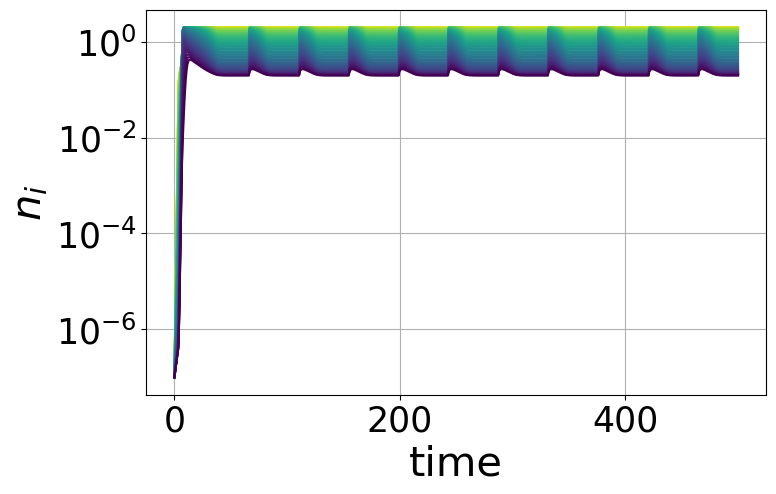

In [15]:
fig,ax=plt.subplots(1,figsize=(8,5))
plt.grid()

colors = pl.cm.viridis_r(np.linspace(0,1,S))
col=0

for s in range(S):
    plt.plot(time_cont,NPt_cont[s,:],label="$p^*=${}".format(p_opt_vec[s]),color=colors[col])
    col+=1
    
    
plt.ylabel("$n_i$",fontsize=30)
plt.xlabel("time",fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
# plt.legend(bbox_to_anchor=(1.,1.),ncol=3,fontsize=20)


# survivors=np.sum((NPt_cont[:-1,-1]>tol))
# print(p_opt_vec[(NPt_cont[:-1,-1]>tol)])
# plt.title("Survivors={}/{}".format(survivors,S),fontsize=25)
# plt.ylim(bottom=1e-2)
plt.yscale("log")
# plt.xscale("log")


plt.savefig("S={}_alpha={}_b={}_pc={}_sig2={}_K={}_fl={}_no_migration.pdf".format(S,al,bconst,pc,sig2,K,fl,tol))

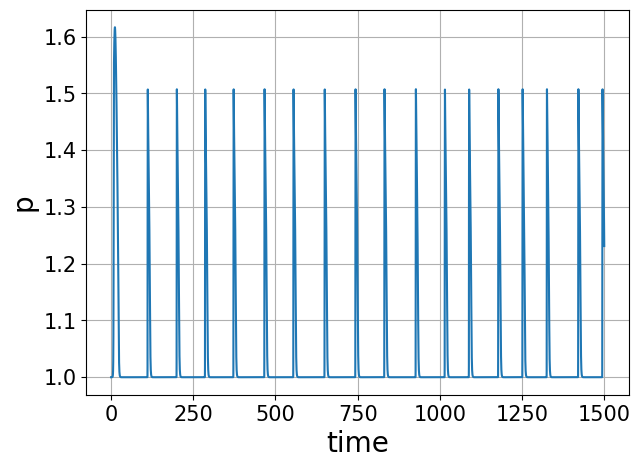

In [11]:
fig,ax=plt.subplots(1,figsize=(7,5))
plt.grid()


plt.plot(time_cont,NPt_cont[-1,:])

    
plt.ylabel("p",fontsize=20)
plt.xlabel("time",fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig("pH_S={}_alpha={}_b={}_pc={}_sig2={}_K={}_fl={}_no_migration_tol={}.pdf".format(S,al,bconst,pc,sig2,K,fl,tol))
#plt.yscale("log")

## Saved set of parameters

In [12]:
## FP : very easy to get

## Limit cycles:

S = 50
bconst=20
b = bconst*np.linspace(-1,1,S)
b=np.flip(b)
pc = 0.4
sig2 = .1
K = 1
al = 2
fl = 1 #stabilize p
p_opt_vec = np.linspace(1.,2,S) # this needs not to be centered in 1
tol=1e-16

my_args=(al,b,K,p_opt_vec,pc,sig2,fl,tol)

t0=0.
tend=500
dt=.1

### I consider different ways of defining the vector $b$:

- $b = \frac{\bar b}{1-p^*}$, with $p^*$ evenly spaced (folder named "b=1/p")
- $b = \bar b [-1,1,S]$ and either same order as $p^*$ or reversed (+ Gaussian noise)